Imports

In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, GRU, SimpleRNN,
    Dense, Dropout, Flatten, BatchNormalization,
    GlobalAveragePooling2D, LeakyReLU
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dropout, BatchNormalization, Attention, Add, Dense, LeakyReLU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import seaborn as sns

Data preprocessing

In [4]:
df_train_data = pd.read_csv("../data/train_data.csv")
df_train_data = df_train_data.dropna(subset=["text"])
df_train_data.head()

,text,sentiment
0,lol get ideas far advance even june yet need t...,1
1,worst headache ever,0
2,sad wont see miss already yeah thats perfect c...,0
3,doesnt know spell conked,1
4,quotso stand one knows us wont get used wont g...,0


In [5]:
df_test_data = pd.read_csv("../data/test_data.csv")
df_test_data = df_test_data.dropna(subset=["text"])
df_test_data.head()

,text,sentiment
0,yes black red fav colors really wanted colors ...,0
1,qu buy open house weekend ampm best value one ...,1
2,fran greet air thats okay hahahaha thanks,1
3,omg thats awesome goood luck u meet caaute cal...,1
4,hahahhaha good point,1


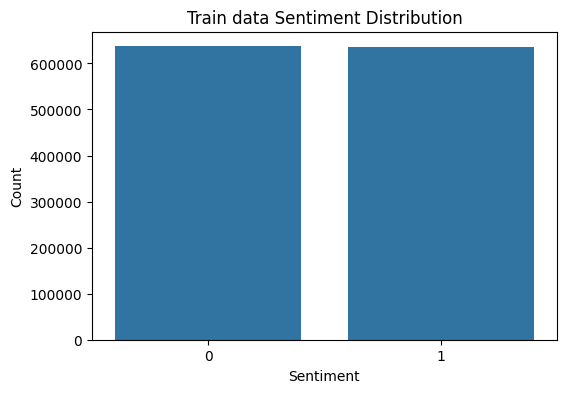

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_train_data, x="sentiment")
plt.title("Train data Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

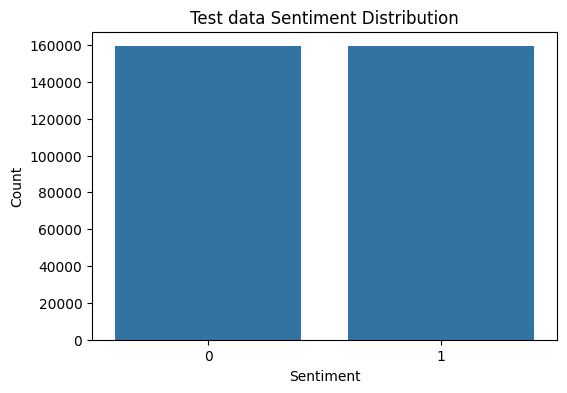

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_test_data, x="sentiment")
plt.title("Test data Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

Tokenizer

In [ ]:
'''
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df_train_data["text"])
# Frequency-sorted list
word_counts = tokenizer.word_counts  # word -> count dictionary
word_freq_df = pd.DataFrame(word_counts.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)
counts = word_freq_df["count"].values
counts_sorted = np.sort(counts)[::-1]  # Descending

# Cumulative token coverage
total_tokens = counts_sorted.sum()
coverage = np.cumsum(counts_sorted) / total_tokens

# Find cutoff for 95% and 99% coverage
cutoff_95 = np.argmax(coverage >= 0.95)
cutoff_99 = np.argmax(coverage >= 0.99)

print(f"Words needed for 95% coverage: {cutoff_95}")
print(f"Words needed for 99% coverage: {cutoff_99}")
'''

Words needed for 95% coverage: 39681
Words needed for 99% coverage: 266592


In [8]:
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train_data["text"])

In [9]:
sequences = tokenizer.texts_to_sequences(df_train_data['text'])
test_sequences = tokenizer.texts_to_sequences(df_test_data['text'])

max_len = max(len(seq) for seq in sequences)

X_train = pad_sequences(sequences, maxlen=max_len, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post')

y_train = df_train_data['sentiment'].values
y_test = df_test_data['sentiment'].values

RNN-LSTM Model

In [10]:
def lstm_block(x, units, return_sequences=False, dp=0.4):
    residual = x
    # Bidirectional LSTM 
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = Dropout(dp)(x)
    x = BatchNormalization()(x)

    attention = Attention()([x, x])
    x = Add()([x, attention])

    if residual.shape[-1] != x.shape[-1]:
        residual = Dense(x.shape[-1])(residual)  
    x = Add()([x, residual])

    if not return_sequences:
        x = GlobalAveragePooling1D()(x)

    return x

In [11]:
from tensorflow.keras.layers import Embedding

def model_lstm_with_embedding(input_shape, vocab_size=50000, embedding_dim=100):
    inputs = Input(shape=input_shape)
    
    # Embedding 
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_shape[0])(inputs)

    # LSTM
    x = lstm_block(x, 512, return_sequences=True)
    x = lstm_block(x, 256, return_sequences=True)
    x = lstm_block(x, 128, return_sequences=True)
    x = lstm_block(x, 64, return_sequences=True)
    x = lstm_block(x, 32, return_sequences=False)

    # Dense 
    for units, rate in [(512, 0.4), (256, 0.4), (128, 0.4), (64, 0.3)]:
        x = Dense(units)(x)
        x = LeakyReLU()(x)  # Leaky ReLU aktivasyon
        x = Dropout(rate)(x)

  
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [12]:
model = model_lstm_with_embedding((max_len,))

Model fit

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=1,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Model predict

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_binary))
print(confusion_matrix(y_test, y_pred_binary))
print(classification_report(y_test, y_pred_binary))

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is already defined with training history data
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()